#Problem definition

Welcome to machine learning project! It focuses on building a regression model to predict the prices of laptops based on their specifications. The data was collected data from a website and will use it to train a model where the independent variables are the laptop specs, and the dependent variable is the price. Our goal is to create a model that accurately predicts the price of a new laptop based on its specs. This will help businesses make informed decisions about pricing and inventory. We will explore, preprocess it, select a suitable regression model, train and evaluate the model, and fine-tune it to achieve the best results. So the problem definition is:

Given laptops' parameters, can we predict the price? 

As a premise, it is intended to be a quick model to assess whether it is worthwhile to purchase a particular product.


#Required Libraries


In [1]:
!pip install fuzzywuzzy
!pip install levenshtein
!pip install pandas_profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 37.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.9/345.9 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.8/679.8 kB 38.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [ ]:
from fuzzywuzzy import fuzz
import requests
from bs4 import BeautifulSoup
import bs4
import csv
import time
from random import uniform
import numpy as np
import pandas as pd
import json
import seaborn as sns
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn import tree
from google.colab import drive
from statsmodels.graphics.gofplots import qqplot
from yellowbrick.model_selection import LearningCurve
from yellowbrick.datasets import load_concrete
import pickle
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/Komputronik/Komputronik_prices
from notebook_scraper_pr import Notebook_Scraper, data_modification
from data_model_evaluation import separate_train_test, scaling_reg_train, quick_rfecv_eval, save_model, linear_model_evaluation, decision_tree_model_evaluation, quick_model_comparision
import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Komputronik/Komputronik_prices


# Notebook_Scraper class

#Scraping

In [ ]:
notebooks = Notebook_Scraper('https://www.komputronik.pl/category/5022/laptopy.html?showBuyActiveOnly=0&p=1')

In [ ]:
notebook_data = notebooks.scrape()

In [ ]:
notebooks.save_data(notebook_data, 'full_data.csv')

In [ ]:
notebook_data = notebooks.open_data('full_data.csv')

#Data 

Data was retrieved from www.komputronik.pl 

##Raw data analysis

The following data shows that there is no missing data for the independent data price, operating system, RAM size, and SSD capacity. In contrast, the other independent values are clearly missing. 

describe() method describes only the dependent variable, since this is the only value that takes numeric values. The maximum price slightly exceeds 30 thousand zlotys, and the average and mean values fluctuate in the range of 5 thousand zlotys. The obtained results indicate that the collected data for the price variable is not characterized by data of concern. 

In [ ]:
df = pd.DataFrame(notebook_data)

In [ ]:
df.sample(5)

,price,price_no_sale,System operacyjny:,Rodzaj laptopa:,Rozdzielczość:,Typ procesora:,Wielkość pamięci RAM:,Pojemność dysku SSD:,Karta graficzna:,Waga:,CPU:,Marka:,Podświetlana klawiatura:,Wbudowany modem:,Przekątna ekranu:,Pojemność dysku SSD 2:,Pojemność dysku SSD 3:,Seria procesora:
3121,3649.00,3649.00,Windows 11 Pro,do domu,1600 x 900 (HD+) pikseli,Intel Core i5,12 GB,500 GB,Intel Iris Xe Graphics,2.1 kg,Core i5-1135G7,Lenovo,NaN,NaN,NaN,NaN,NaN,NaN
1633,2164.79,2164.79,Windows 11 Home,do domu,1920 x 1080 (Full HD) pikseli,Intel Core i5,8 GB,512 GB,Intel Iris Xe Graphics,1.65 kg,Core i5-1135G7,Lenovo,NaN,NaN,NaN,NaN,NaN,NaN
1212,2549.00,2549.00,Windows 11 Home,do domu,1920 x 1080 (Full HD) pikseli,AMD Ryzen 5,8 GB,1000 GB,AMD Radeon Graphics,1.69 kg,AMD Ryzen 5 5625U,HP,NaN,NaN,NaN,NaN,NaN,NaN
1425,5490.00,5490.00,Windows 11 Home,do gier,1920 x 1080 (Full HD) pikseli,Intel Core i7,32 GB,1000 GB,NVIDIA Geforce RTX 3050 Ti Laptop GPU,NaN,Corei7-11800H,MSI,NaN,NaN,NaN,960 GB,NaN,NaN
1323,8990.00,8990.00,Windows 11 Pro,biznesowy,1920 x 1080 (Full HD) pikseli,Intel Core i5,16 GB,512 GB,Intel Iris Xe Graphics,1.8 kg,Core i5-1245U,DELL,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3482 entries, 0 to 3481
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   price                     3482 non-null   float64
 1   price_no_sale             3482 non-null   float64
 2   System operacyjny:        3482 non-null   object 
 3   Rodzaj laptopa:           3479 non-null   object 
 4   Rozdzielczość:            3465 non-null   object 
 5   Typ procesora:            3481 non-null   object 
 6   Wielkość pamięci RAM:     3482 non-null   object 
 7   Pojemność dysku SSD:      3481 non-null   object 
 8   Karta graficzna:          3424 non-null   object 
 9   Waga:                     833 non-null    object 
 10  CPU:                      3482 non-null   object 
 11  Marka:                    3482 non-null   object 
 12  Podświetlana klawiatura:  1904 non-null   object 
 13  Wbudowany modem:          42 non-null     object 
 14  Przekątn

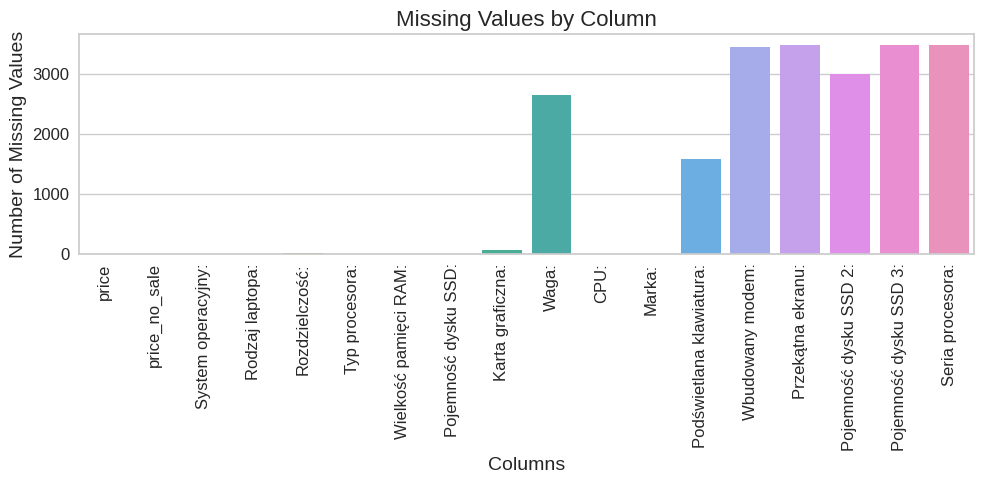

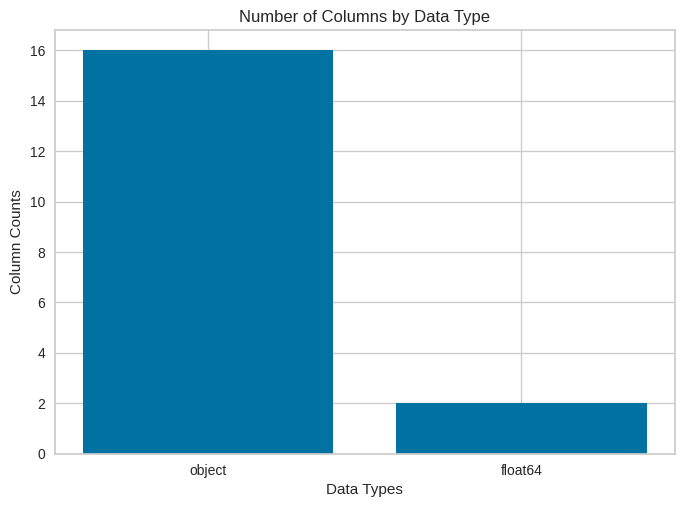

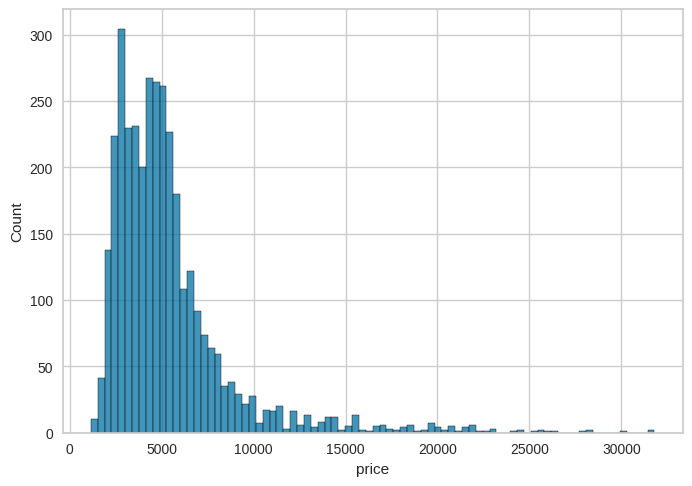

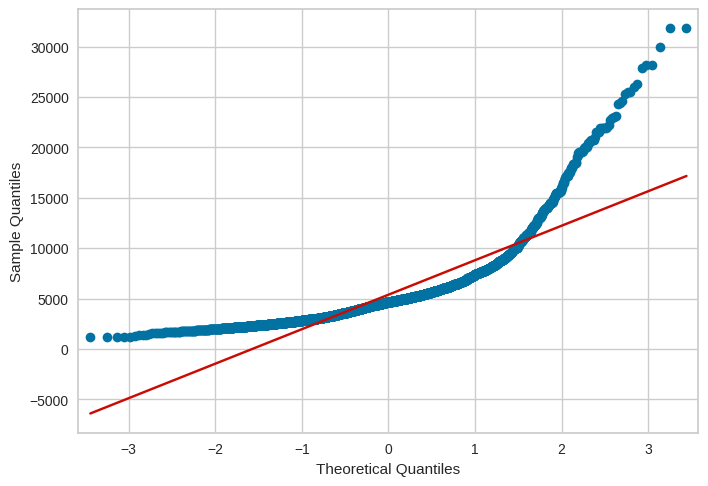

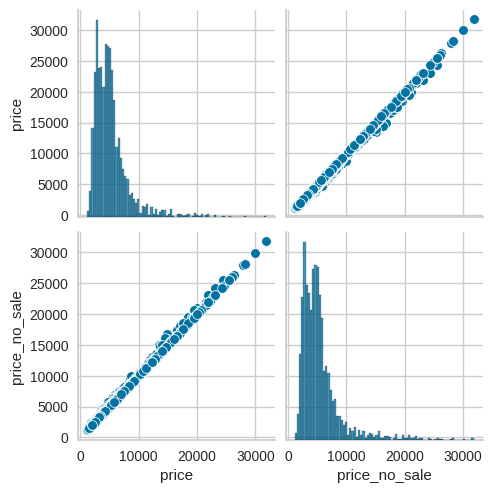

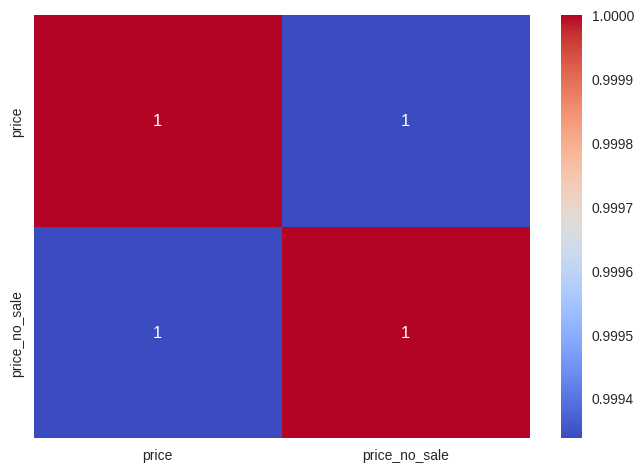

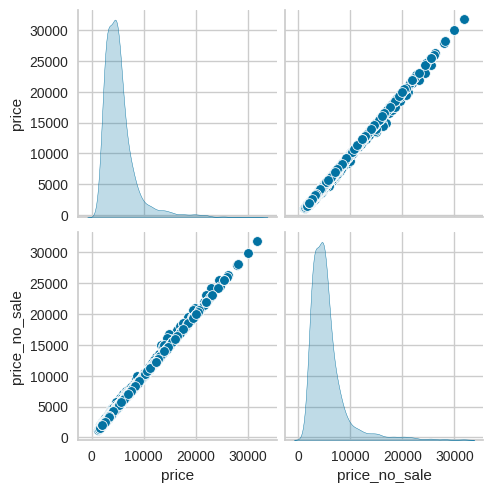

In [ ]:
def explore_data_regression(dataset_file, target_column_name):
    # Examine the data
    missing_values = dataset_file.isnull().sum()
    plt.figure(figsize=(10, 5))
    sns.barplot(x=missing_values.index, y=missing_values.values)
    plt.title('Missing Values by Column', fontsize=16)
    plt.xlabel('Columns', fontsize=14)
    plt.ylabel('Number of Missing Values', fontsize=14)
    plt.xticks(rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tight_layout()
    plt.show()
    print('\n')
    counts = dataset_file.dtypes.value_counts()
    plt.bar(counts.index.astype(str), counts.values)
    plt.xlabel('Data Types')
    plt.ylabel('Column Counts')
    plt.title('Number of Columns by Data Type')
    plt.show()
    print('\n')
    # Check the distribution of the target variable
    sns.histplot(df[target_column_name])
    plt.show()
    print('\n')
    qqplot(df[target_column_name], line='s')
    plt.show()  
    print('\n')
    # Check the distribution of the numerical features
    num_cols = [col for col in df if df[col].dtype != "object" or df[col].dtype != "bool"]
    sns.pairplot(data=df[num_cols])
    plt.show()
    print('\n')
    # Check the correlation between all features
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
    plt.show()
    print('\n')
    # Check the correlation between all numerical features
    sns.pairplot(data=df[num_cols], diag_kind="kde")
    plt.show()
    print('\n')


explore_data_regression(df, 'price')

In [ ]:
data_analysis(df)

##Raw data exploring

After the first analysis, it can be seen that all the variables used are correlated with the price of the product. However, the graphics card, the weight and the presence of a second SSD drive have the highest correlation. However, the latter two features have many outliers, which can greatly distort the true correlation.

Therefore, the first model is trained on data that is also important and there is no shortage of data, namely the type of operating system, resolution, RAM size, and SSD size. 

The operating system is divided into Windows, Mac OS, Chrome OS, and Linux, so it can be inferred that the price depends on the system, especially when we compare Windows-based devices with Mac OS-based devices.

Due to the lack of data regarding the screen size, the data is processed by multiplying the height by the width, which gives us a numerical data that somehow determines the resolution. 

RAM size and SSD size have also been converted to numerical values. 

As a result, we will be able to compare models for which values have been taken in both categorical and numerical forms.



In [ ]:
from pandas_profiling import ProfileReport
prof = ProfileReport(df, infer_dtypes=False)
prof

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

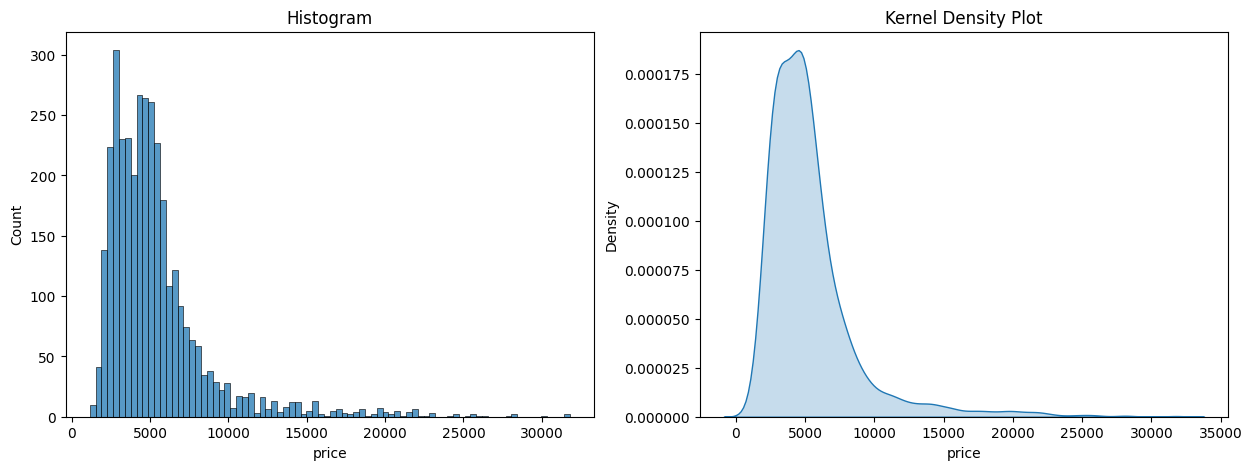

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

sns.histplot(data=df, x='price', kde=False, ax=ax1)
ax1.set_title('Histogram')

sns.kdeplot(data=df, x='price', fill=True, ax=ax2)
ax2.set_title('Kernel Density Plot')

plt.show()

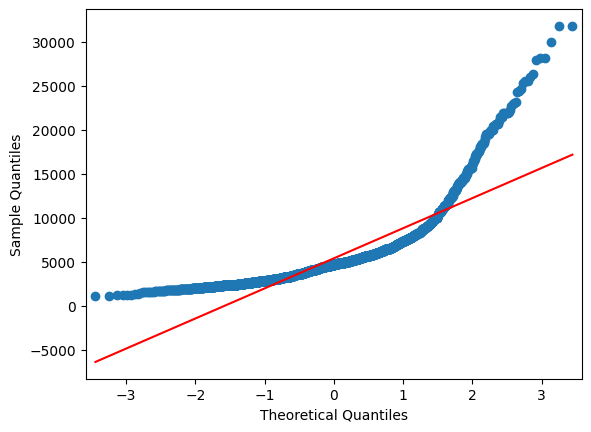

In [ ]:

qqplot(df['price'], line='s')
plt.show()

In [ ]:
from scipy.stats import shapiro

stat, p = shapiro(df['price'])
print(f'Shapiro-Wilk test: stat={round(stat, 2)}, p={round(p, 2)}')

Shapiro-Wilk test: stat=0.74, p=0.0


In [ ]:
df = pd.DataFrame(notebook_data)
top_systems = df['System operacyjny:'].value_counts()[:6].index.tolist()
df['System operacyjny:'] = np.where(df['System operacyjny:'].isin(top_systems), df['System operacyjny:'], 'other_system')

In [ ]:
np.where(df['System operacyjny:'].isin(df['System operacyjny:'].value_counts()[:6].index), df['System operacyjny:'], 'other_system')

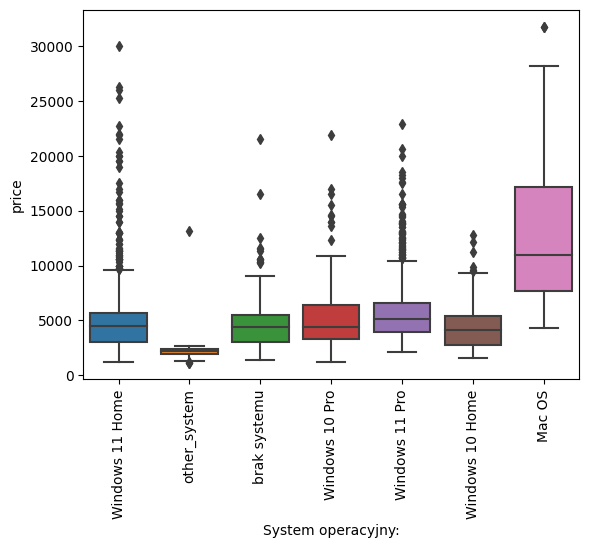

In [ ]:
sns.boxplot(x="System operacyjny:", y="price", data=df)
plt.xticks(rotation=90)
plt.show()

In [ ]:
df = pd.DataFrame(notebook_data)
df['System operacyjny:'] = df['System operacyjny:'].map(lambda x: 'Windows' if x.lower().startswith('windows') else x)

In [ ]:
df['System operacyjny:'].value_counts()

Windows         2579
brak systemu     728
Mac OS           169
Chrome OS          5
Linux              1
Name: System operacyjny:, dtype: int64

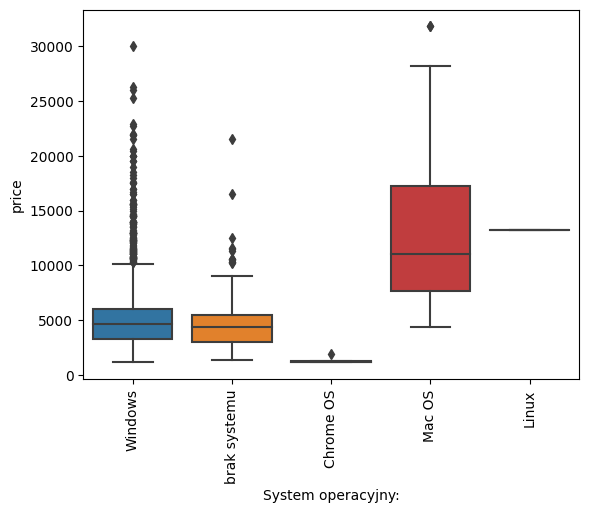

In [ ]:
sns.boxplot(x="System operacyjny:", y="price", data=df)
plt.xticks(rotation=90)
plt.show()

In [ ]:
df = pd.DataFrame(notebook_data)

df1 = df.copy()
df2 = df.copy()

top_ram = df1['Wielkość pamięci RAM:'].value_counts()[:5].index.tolist()

df1['Wielkość pamięci RAM:'] = np.where(df1['Wielkość pamięci RAM:'].isin(top_ram), df1['Wielkość pamięci RAM:'], 'other_ram')
df2['Wielkość pamięci RAM:'] = df2['Wielkość pamięci RAM:'].str.split(' ').map(lambda x: x[0]).astype(int)

In [ ]:
df1['Wielkość pamięci RAM:'].value_counts()

16 GB        1611
8 GB          862
32 GB         738
12 GB         144
other_ram      76
64 GB          51
Name: Wielkość pamięci RAM:, dtype: int64

In [ ]:
df2['Wielkość pamięci RAM:'].value_counts()

16    1611
8      862
32     738
12     144
64      51
4       43
24      27
96       5
40       1
Name: Wielkość pamięci RAM:, dtype: int64

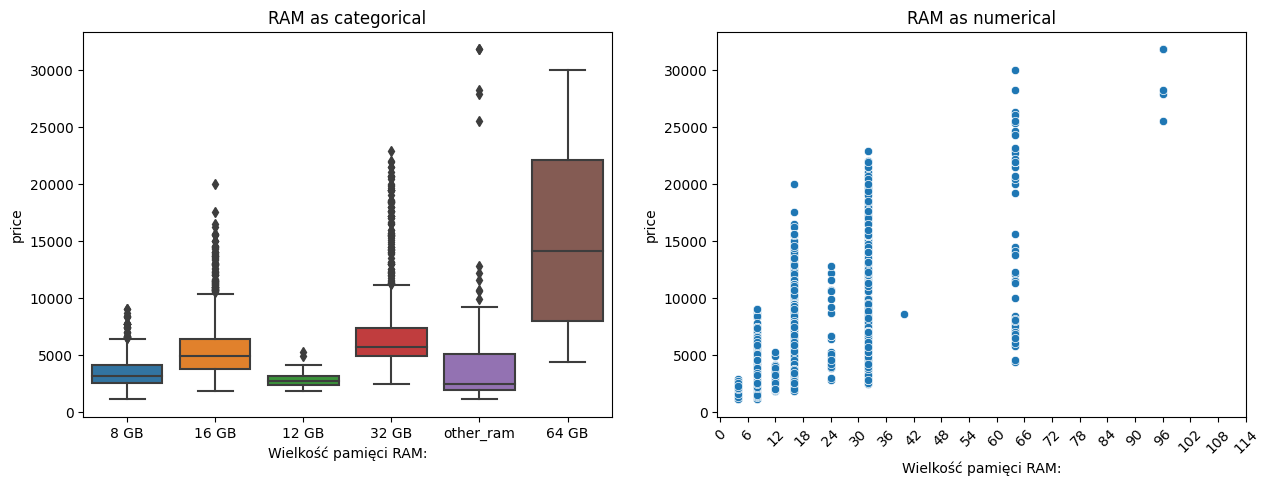

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

sns.boxplot(x="Wielkość pamięci RAM:", y="price", data=df1, ax=ax1)
plt.xticks(rotation=90)
ax1.set_title('RAM as categorical')

sns.scatterplot(x="Wielkość pamięci RAM:", y="price", data=df2)
plt.xticks(range(0, 120, 6),
           rotation=45)
ax2.set_title('RAM as numerical')

plt.show()

In [ ]:
df = pd.DataFrame(notebook_data)

df1 = df.copy()
df2 = df.copy()

top_ssd = df1['Pojemność dysku SSD:'].value_counts()[:5].index.tolist()

df1['Pojemność dysku SSD:'] = np.where(df1['Pojemność dysku SSD:'].isin(top_ssd), df1['Pojemność dysku SSD:'], 'other_hardware')

most_common_ssd = df2['Pojemność dysku SSD:'].value_counts().head().index[0]
df2['Pojemność dysku SSD:'].fillna(most_common_ssd, inplace=True)
df2['Pojemność dysku SSD:'] = df2['Pojemność dysku SSD:'].apply(lambda x: x.split(' ')[0]).astype(int)


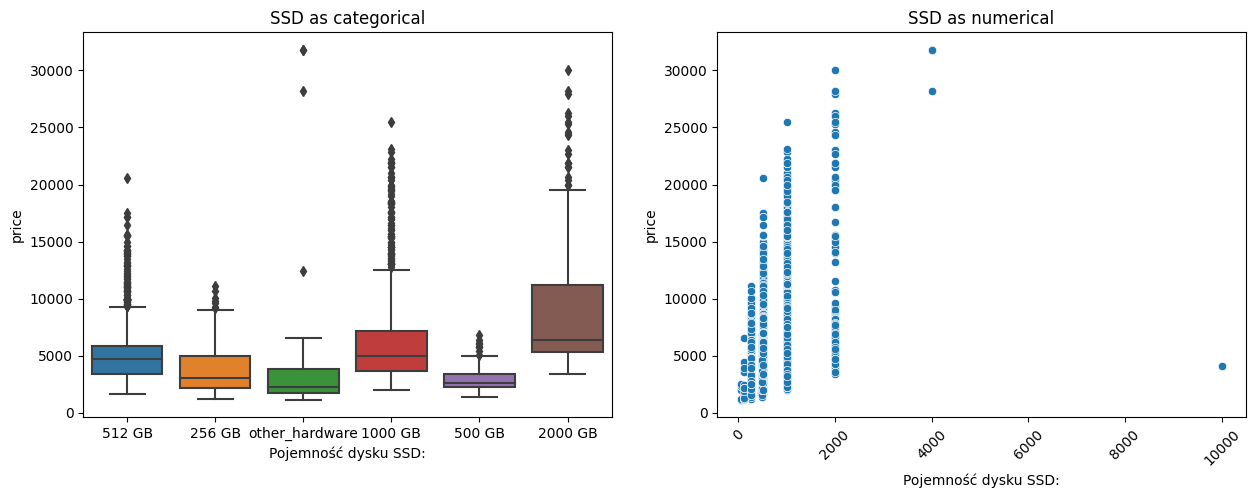

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

sns.boxplot(x="Pojemność dysku SSD:", y="price", data=df1, ax=ax1)
plt.xticks(rotation=90)
ax1.set_title('SSD as categorical')

sns.scatterplot(x="Pojemność dysku SSD:", y="price", data=df2)
plt.xticks(rotation=45)
ax2.set_title('SSD as numerical')

plt.show()

In [ ]:
df2['Pojemność dysku SSD:'].value_counts()

In [ ]:
ssd_threshold = 4000
price_threshold = np.percentile(df['price'], 75)
conditions = (df2['Pojemność dysku SSD:'] > ssd_threshold) & (df2['price'] < price_threshold)
df2.drop(index=df2[conditions].index, inplace=True)

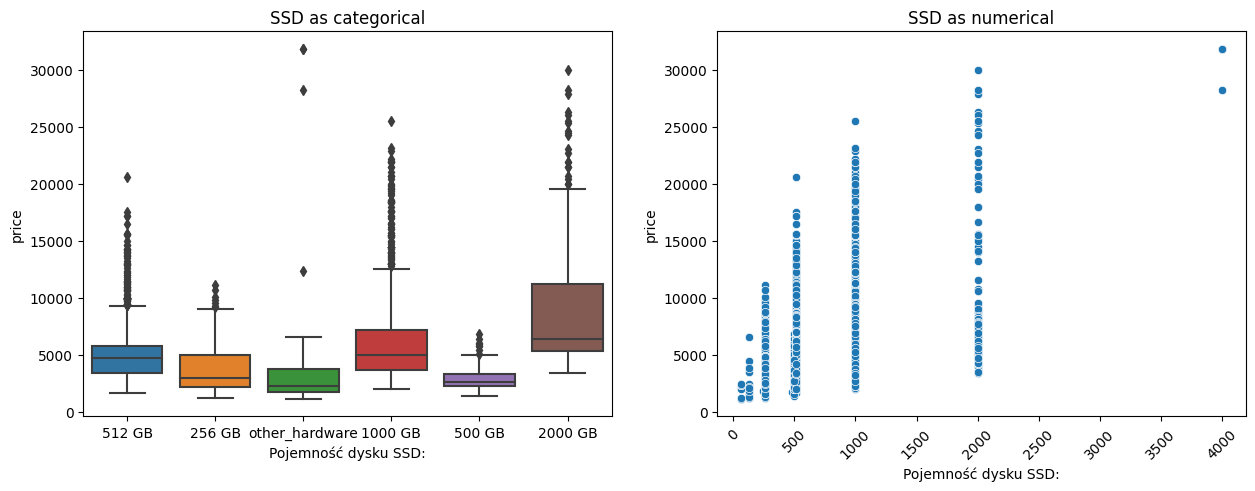

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

sns.boxplot(x="Pojemność dysku SSD:", y="price", data=df1, ax=ax1)
plt.xticks(rotation=90)
ax1.set_title('SSD as categorical')

sns.scatterplot(x="Pojemność dysku SSD:", y="price", data=df2)
plt.xticks(rotation=45)
ax2.set_title('SSD as numerical')

plt.show()

In [ ]:
df.info()

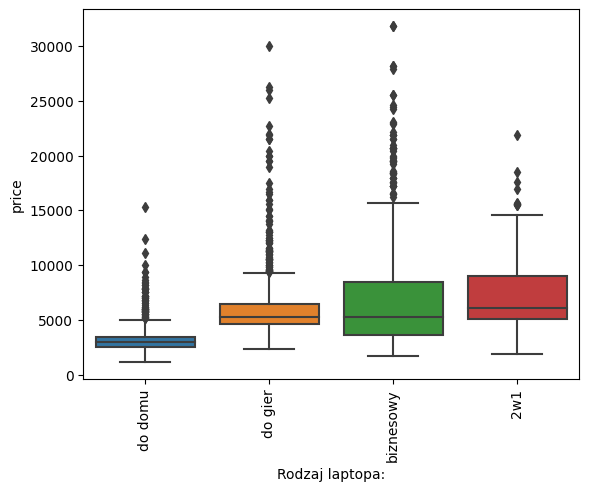

In [ ]:
df = pd.DataFrame(notebook_data)

df2 = df.copy()

sns.boxplot(x="Rodzaj laptopa:", y="price", data=df2)
plt.xticks(rotation=90)

plt.show()

#SANDBOX

##Clear and scale

##Training with dimensionality reduction

In [ ]:
df = pd.DataFrame(notebook_data)

In [ ]:
X_train, X_test, y_train, y_test = separate_train_test(df, 'price')

In [ ]:
X_train_mod, y_train_mod = data_modification(X_train, y_train) # scale for test

{'NVIDIA GeForce RTX 4090': 325929, 'NVIDIA RTX 6000 Ada Generation': 312956, 'NVIDIA Graphics Device': 254531, 'NVIDIA GeForce RTX 4080': 245613, 'NVIDIA A100 80GB PCIe': 214586, 'GeForce RTX 3080 Ti': 209081, 'NVIDIA GeForce RTX 4070 Ti': 208189, 'NVIDIA GeForce RTX 3090 Ti': 207913, 'NVIDIA A100-PCIE-80GB': 207124, 'RTX A6000': 200330, 'AMD Radeon RX 7900 XTX': 198521, 'NVIDIA RTX A6000': 198288, 'GRID A100-7-40C MIG 7g.40gb': 196825, 'NVIDIA GeForce RTX 3090': 195972, 'NVIDIA GeForce RTX 3080 Ti': 192540, 'NVIDIA A40': 192412, 'GeForce RTX 3090': 191233, 'Radeon RX 7900 XTX': 185417, 'NVIDIA A40-48Q': 180109, 'NVIDIA GeForce RTX 4090 Laptop GPU': 179704, 'AMD Radeon RX 7900 XT': 178436, 'GeForce RTX 3080': 176507, 'NVIDIA A40-12Q': 174796, 'NVIDIA GeForce RTX 3080': 174463, 'AMD Radeon RX 6950 XT': 173498, 'NVIDIA A10G': 172506, 'Quadro GV100': 168515, 'NVIDIA GeForce RTX 4070': 166630, 'Tesla V100-SXM2-16GB': 165315, 'NVIDIA A10': 164239, 'NVIDIA GeForce RTX 4080 Laptop GPU': 1611

In [ ]:
X = X_train_mod[['System operacyjny:', 'Rodzaj laptopa:', 'Rozdzielczość:', 'Wielkość pamięci RAM:', 'Pojemność dysku SSD:', 'Marka:', 'GPU benchmark:', 'CPU benchmark:']]
y = y_train_mod

In [ ]:
scaled_x, scaled_y, scaler_x, scaler_y, ohe = scaling_reg_train(X, y)

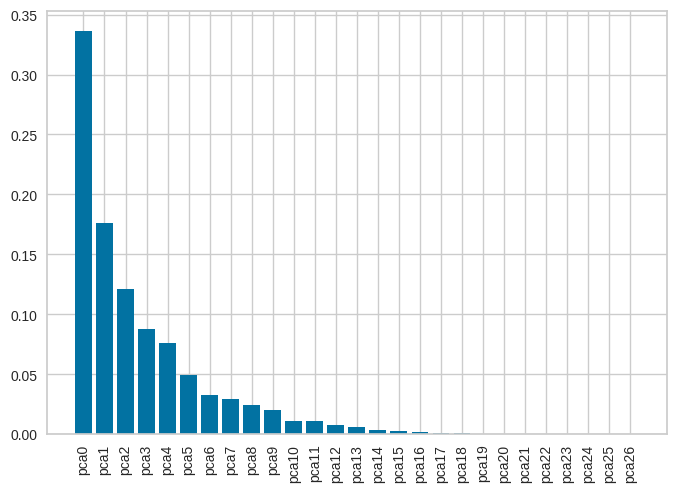

In [ ]:
pca = PCA()

X_pca = pca.fit_transform(scaled_x)

plt.bar(pca.get_feature_names_out(),
        pca.explained_variance_ratio_)

plt.xticks(rotation=90)

plt.show()

In [ ]:
quick_rfecv_eval(X_pca, scaled_y)

##Model evaluation

###Linear Regression

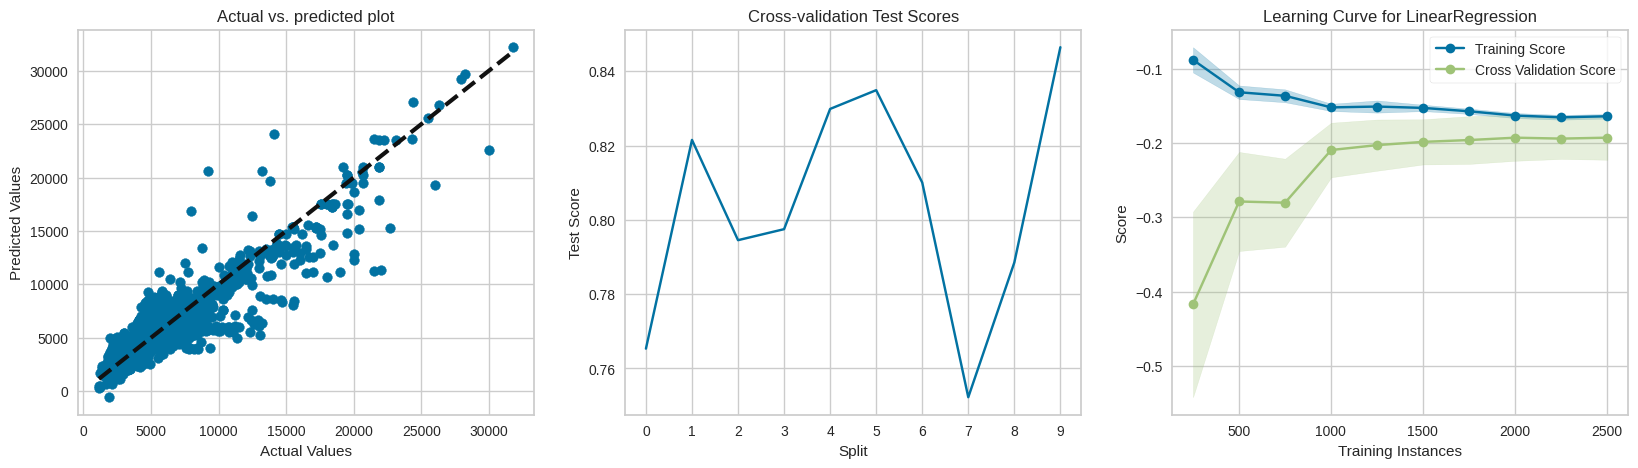



best parameters : {'pca__n_components': 10, 'polynomial__degree': 2}
best score : 0.804085702520814
MAE (on train set) : 883.1564750049629
MAPE (on train set) : 0.17330249361082775
mean_fit_time : 0.047217297554016116
std_fit_time : 0.0018427370592174754
all_best_split_scores : [0.7653425845474083 0.8215043455356179 0.7945260252659864
 0.7974893008663161 0.8298417625119309 0.8348895156217055
 0.8100417547973364 0.7522670792659144 0.7885094157379517
 0.8464452410579733]


In [ ]:
lr, lr_results = linear_model_evaluation(LinearRegression(),
                                          scaled_x,
                                         scaled_y,
                                         scaler_y,
                                         params={'polynomial__degree': [1, 2],
                                                 'pca__n_components': [None, 2, 4, 6, 8, 10]})


In [ ]:
pca = PCA(10)

X_pca = pca.fit_transform(scaled_x)

In [ ]:
poly_features = PolynomialFeatures(degree=2)
x_poly = poly_features.fit_transform(X_pca)

# Fit the linear regression model to the polynomial features
lr = LinearRegression()
lr.fit(x_poly, scaled_y)
y_pred = lr.predict(x_poly)

In [ ]:
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).ravel()
y_train_orig = scaler_y.inverse_transform(scaled_y.reshape(-1, 1)).ravel()
print(mean_absolute_error(y_train_orig, y_pred))
print(mean_absolute_percentage_error(y_train_orig, y_pred))

In [ ]:
print(mean_absolute_error(y_train_orig, y_pred))
print(mean_absolute_percentage_error(y_train_orig, y_pred))
             

883.1564746194067
0.17330249324661562


In [ ]:
X_test_mod, y_test_mod = data_modification(X_test, y_test)

{'NVIDIA GeForce RTX 4090': 325929, 'NVIDIA RTX 6000 Ada Generation': 312956, 'NVIDIA Graphics Device': 254531, 'NVIDIA GeForce RTX 4080': 245613, 'NVIDIA A100 80GB PCIe': 214586, 'GeForce RTX 3080 Ti': 209081, 'NVIDIA GeForce RTX 4070 Ti': 208189, 'NVIDIA GeForce RTX 3090 Ti': 207913, 'NVIDIA A100-PCIE-80GB': 207124, 'RTX A6000': 200330, 'AMD Radeon RX 7900 XTX': 198521, 'NVIDIA RTX A6000': 198288, 'GRID A100-7-40C MIG 7g.40gb': 196825, 'NVIDIA GeForce RTX 3090': 195972, 'NVIDIA GeForce RTX 3080 Ti': 192540, 'NVIDIA A40': 192412, 'GeForce RTX 3090': 191233, 'Radeon RX 7900 XTX': 185417, 'NVIDIA A40-48Q': 180109, 'NVIDIA GeForce RTX 4090 Laptop GPU': 179704, 'AMD Radeon RX 7900 XT': 178436, 'GeForce RTX 3080': 176507, 'NVIDIA A40-12Q': 174796, 'NVIDIA GeForce RTX 3080': 174463, 'AMD Radeon RX 6950 XT': 173498, 'NVIDIA A10G': 172506, 'Quadro GV100': 168515, 'NVIDIA GeForce RTX 4070': 166630, 'Tesla V100-SXM2-16GB': 165315, 'NVIDIA A10': 164239, 'NVIDIA GeForce RTX 4080 Laptop GPU': 1611

In [ ]:
X = X_test_mod[['System operacyjny:', 'Rodzaj laptopa:', 'Rozdzielczość:', 'Wielkość pamięci RAM:', 'Pojemność dysku SSD:', 'Marka:', 'GPU benchmark:', 'CPU benchmark:']]
y = y_test_mod

In [ ]:
def scaling_reg_test(X, y, scaler_x=None, scaler_y=None, ohe=None):
    """
    Preprocesses the input data for regression testing by scaling and encoding the features and target.

    Args:
        X (pandas.DataFrame): The input feature data.
        y (pandas.Series): The target data.
        scaler_x (object, optional): The scaler to use for the feature data. Default is None.
        scaler_y (object, optional): The scaler to use for the target data. Default is None.
        ohe (object, optional): The encoder to use for the categorical features. Default is None.

    Returns:
        tuple: The preprocessed feature and target data.
    """
    numeric, category = 0, 0

    if scaler_x and not scaler_y:
        scaled_x = scaler_x.transform(X.select_dtypes(exclude=['object', 'bool']))
        numeric += 1
    elif not scaler_x and scaler_y:
        encoded_x = ohe.transform(X.select_dtypes(include=['object', 'bool']))
        category += 1
    else:
        scaled_x = scaler_x.transform(X.select_dtypes(exclude=['object', 'bool']))
        encoded_x = ohe.transform(X.select_dtypes(include=['object', 'bool']))

    scaled_y = scaler_y.fit_transform(y)

    if numeric == 1 and category == 1:
        processed_data = np.concatenate([scaled_x, encoded_x], axis=1)
        return processed_data, scaled_y
    elif numeric == 1 and category == 0:
        return scaled_x, scaled_y
    else:
        return encoded_x, scaled_y

In [ ]:
scaled_x, scaled_y = scaling_reg_test(X, y, scaler_x, scaler_y, ohe)

In [ ]:
pca = PCA(10)

X_pca = pca.fit_transform(scaled_x)

In [ ]:
poly_features = PolynomialFeatures(degree=2)
x_poly = poly_features.fit_transform(X_pca)

# Fit the linear regression model to the polynomial features
lr = LinearRegression()
lr.fit(x_poly, scaled_y)
y_pred = lr.predict(x_poly)

In [ ]:
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).ravel()
y_train_orig = scaler_y.inverse_transform(scaled_y.reshape(-1, 1)).ravel()
print(mean_absolute_error(y_train_orig, y_pred))
print(mean_absolute_percentage_error(y_train_orig, y_pred))

1953.3511516881058
0.3818865856158795


###Ridge



best parameters : {'pca__n_components': 10, 'polynomial__degree': 2}
best score : 0.8059372878242451
MAE (on train set) : 882.6995684420037
MAPE (on train set) : 0.1731192455542323
mean_fit_time : 0.14652864933013915
std_fit_time : 0.03441030689814356
all_best_split_scores : [0.7656537655292307 0.8211749787776388 0.7962686702243252
 0.7974592313660274 0.8317018121092616 0.8382932840583686
 0.8123329590003299 0.756243844785801 0.7943546743675207
 0.8458896580239471]


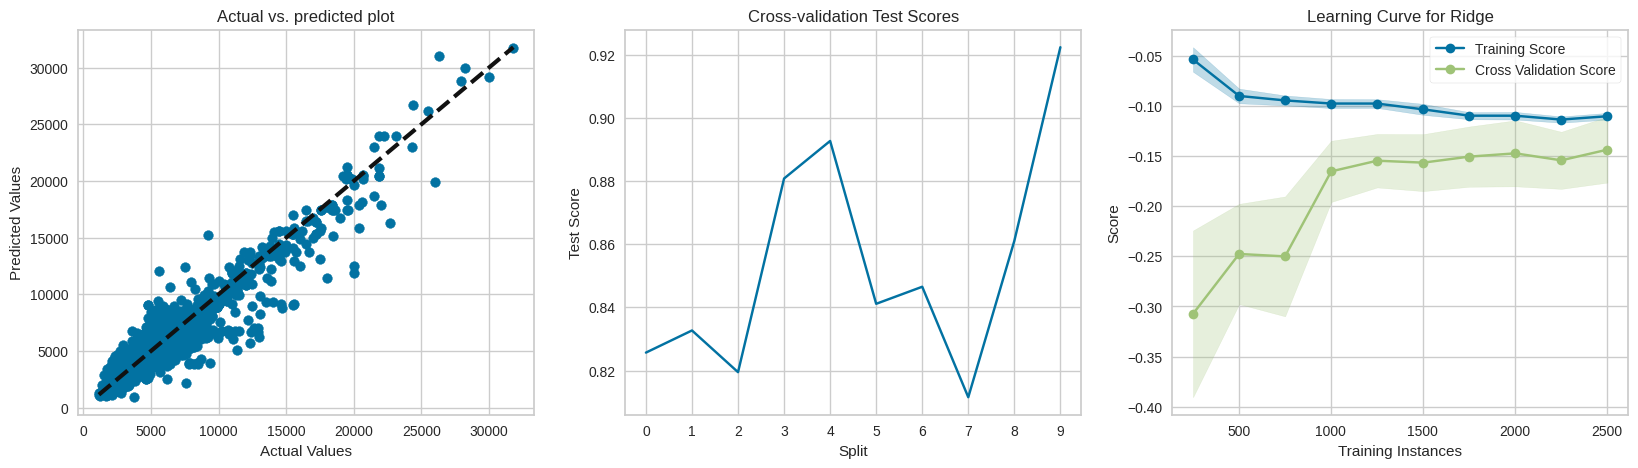



best parameters : {'actual_model__alpha': 1, 'actual_model__fit_intercept': False, 'pca__n_components': None, 'polynomial__degree': 2}
best score : 0.8533847550002719
MAE (on train set) : 762.7213154213373
MAPE (on train set) : 0.1557790926439208
mean_fit_time : 0.0836043119430542
std_fit_time : 0.019838832600160262
all_best_split_scores : [0.8256826297376837 0.832689622203759 0.8194983413408256
 0.8807739462442162 0.8926525674337488 0.841124098856966
 0.8465211145927334 0.8115660930424722 0.861026541421846 0.922312595128468]


In [ ]:
lr_ridge, lr_results_ridge = linear_model_evaluation(Ridge(), scaled_x, scaled_y, scaler_y, params={
    'actual_model__alpha': [0.1, 1, 10],
    'actual_model__fit_intercept': [True, False],
    'polynomial__degree': [1, 2],
    'pca__n_components': [None, 2, 4, 6, 8, 10]})



###Lasso

In [ ]:
lr_lasso, lr_results_lasso = linear_model_evaluation(Lasso(),
                                                    scaled_x,
                                                    scaled_y,
                                                    scaler_y,
                                                    params={'actual_model__alpha': [0.1, 1, 10],
                                                            'actual_model__max_iter': np.arange(500, 5001, 500),
                                                            'actual_model__selection': ['cyclic', 'random'],
                                                            'polynomial__degree': [1, 2, 3, 4, 5],
                                                            'pca__n_components': [None, 2, 4, 6, 8, 10]})


###SVR

In [ ]:
svr, svr_results = linear_model_evaluation(SVR(),
                                          scaled_x,
                                         scaled_y,
                                         scaler_y,
                                         params = {
                                                    'polynomial__degree': [1, 2],
                                                    'actual_model__C': [0.1, 1, 10],
                                                    'actual_model__kernel': ['linear', 'rbf'],
                                                   'pca__n_components': [None, 2, 4, 6, 8, 10]
                                                    })

###KNN

In [ ]:
knn, knn_results = linear_model_evaluation(KNeighborsRegressor(),
                                          scaled_x,
                                         scaled_y,
                                         scaler_y,
                                         params = { 
                                                    'polynomial__degree': [1, 2],
                                                    'actual_model__n_neighbors': [3, 5, 7],
                                                    'actual_model__weights': ['uniform', 'distance'],
                                                    'actual_model__p': [1, 2],
                                                    'actual_model__leaf_size': [10, 20, 30],
                                                   'pca__n_components': [None, 2, 4, 6, 8, 10]})



###Decision Tree

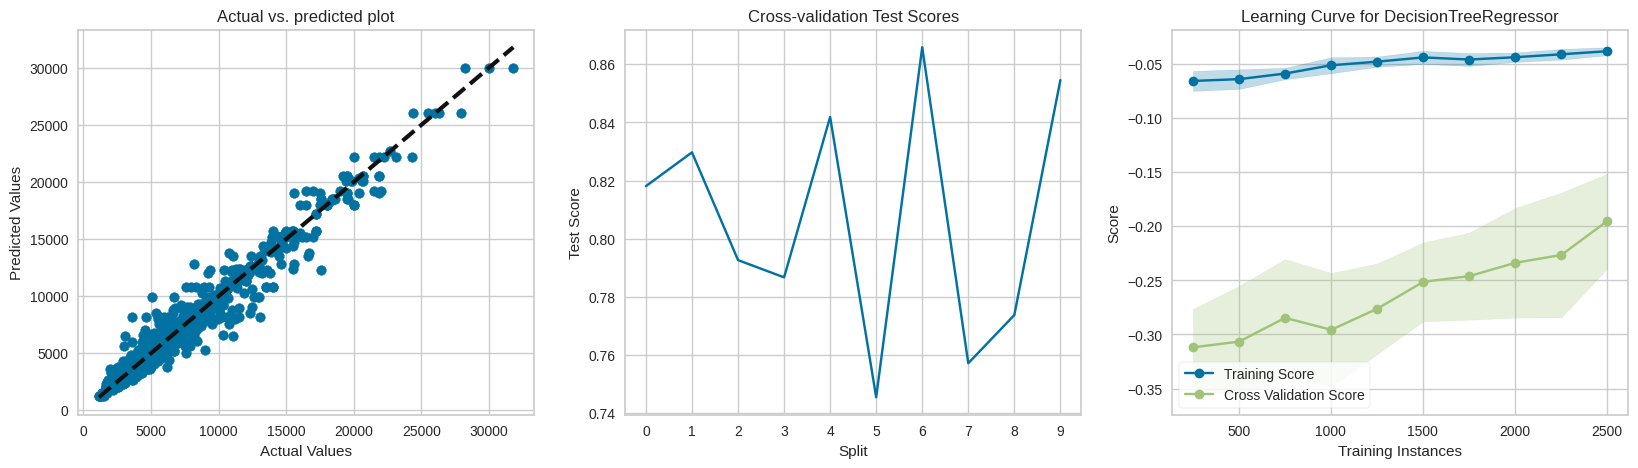



best parameters : {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 8}
best score : 0.8065883040210288
MAE (on train set) : 366.2355729406689
MAPE (on train set) : 0.07187410905982371
mean_fit_time : 0.007828545570373536
std_fit_time : 0.0002093402302975235
all_best_split_scores : [0.8180860409691442 0.8297102466429512 0.7926532510286737
 0.7867090266001959 0.841862698693123 0.7454905892032928
 0.8658619255993967 0.7571828629538453 0.7737530497992544
 0.8545733487204095]


In [ ]:
tree, tree_results = decision_tree_model_evaluation(DecisionTreeRegressor(),
                                                    X_pca,
                                                    scaled_y,
                                                    scaler_y,
                                                    params={'actual_model__max_depth': np.arange(1, 30),
                                                            'actual_model__min_samples_split': [2, 4, 6, 8, 10],
                                                            'actual_model__min_samples_leaf': [1, 3, 5, 7, 9],
                                                            'pca__n_components': [None, 2, 4, 6, 8, 10]})



###Random Foest

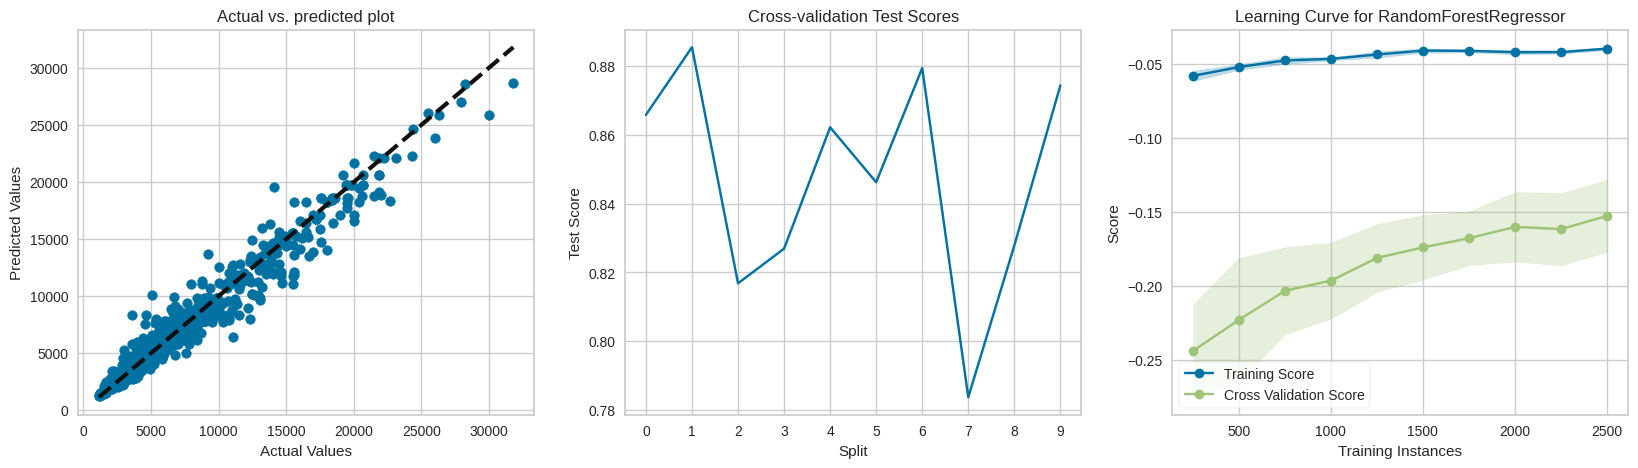



best parameters : {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
best score : 0.846879126964482
MAE (on train set) : 387.07050203070065
MAPE (on train set) : 0.07556567839481157
mean_fit_time : 0.7882064819335938
std_fit_time : 0.16180364816475545
all_best_split_scores : [0.8658193088123708 0.8854825132191684 0.8168325096978625
 0.8269104233622557 0.8622046416697912 0.8462186134163256
 0.8794198494011571 0.7837072077178359 0.8278246523758113
 0.8743715499722419]


In [ ]:
rf, rf_results = decision_tree_model_evaluation(RandomForestRegressor(),
                                                    X_pca,
                                                    scaled_y,
                                                    scaler_y,
                                                    params={
                                                            'actual_model__n_estimators': [100, 1000, 2500],
                                                            'actual_model__max_depth': [None, 10, 50],
                                                            'actual_model__min_samples_split': [5, 10],
                                                            'pca__n_components': [None, 2, 4, 6, 8, 10]})



###Gradient Boosting

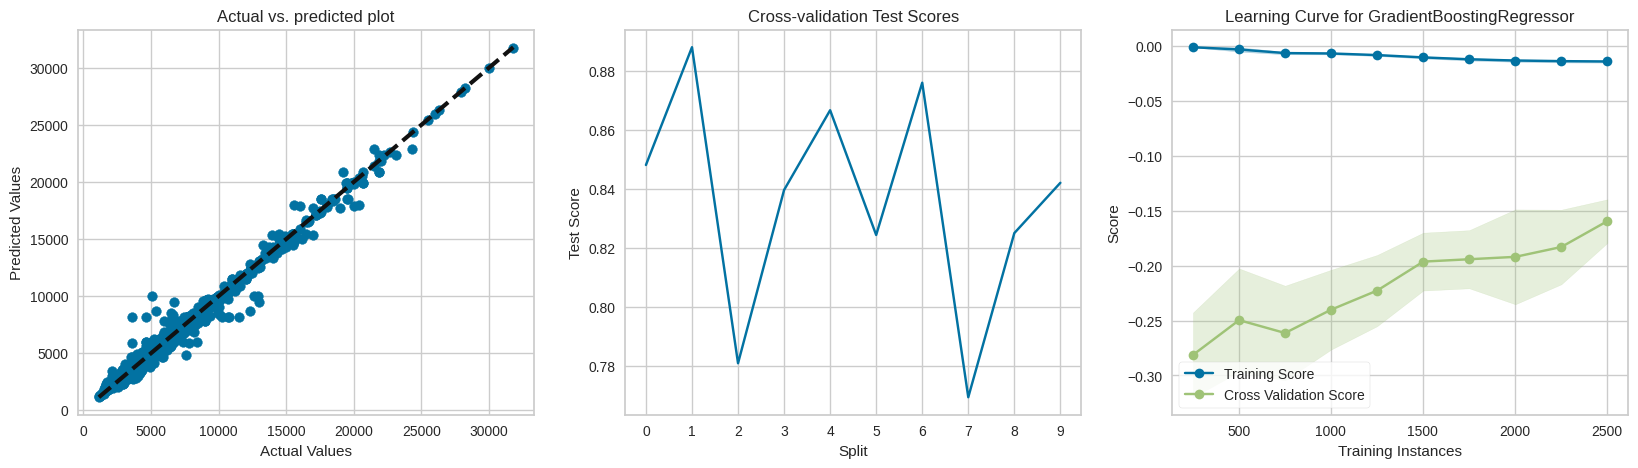



best parameters : {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
best score : 0.835985806435201
MAE (on train set) : 248.87112969303567
MAPE (on train set) : 0.05545032912785155
mean_fit_time : 0.9783103942871094
std_fit_time : 0.13363336322336453
all_best_split_scores : [0.8480934875036723 0.8880904694880039 0.7807692492390279
 0.8396041896182129 0.8666944954383747 0.824323598752619
 0.8760328200956415 0.7692306317818159 0.8249685500210538
 0.842050572413588]


In [ ]:
rf_boosted, rf_boosted_results = decision_tree_model_evaluation(GradientBoostingRegressor(),
                                                    X_pca,
                                                    scaled_y,
                                                    scaler_y,
                                                    params={
                                                            'actual_model__n_estimators': [10, 100, 1000],
                                                            'actual_model__max_depth': [None, 10, 50],
                                                            'actual_model__min_samples_split': [5, 10],
                                                            'pca__n_components': [None, 2, 4, 6, 8, 10]})


###Multi-layer Perceptron regressor

In [ ]:
mlp, mlp_results = linear_model_evaluation(MLPRegressor(),
                                           scaled_x,
                                           scaled_y,
                                           scaler_y,
                                           params = {
    'actual_model__max_iter': [150],
    'actual_model__hidden_layer_sizes': [(16,8,6,2), (32,16,12,4)],
    'actual_model__activation': ['identity', 'relu', 'logistic'],
    'actual_model__solver': ['adam', 'sgd', 'lbfgs'],
    'actual_model__learning_rate': ['constant', 'adaptive'],
    'pca__n_components': [None, 2, 4, 6, 8, 10, 12, 14, 16]
})

In [ ]:
mlp2, mlp_results2 = linear_model_evaluation(MLPRegressor(),
                                           scaled_x,
                                           scaled_y,
                                           scaler_y,
                                           params = {
    'actual_model__hidden_layer_sizes': [(128,64,28,16), (64,32,24,8), (32,16,12,4)],
    'actual_model__activation': ['relu',],
    'actual_model__solver': ['lbfgs'],
    'actual_model__learning_rate': ['constant'],
    'pca__n_components': [None, 12, 14, 16]
})

In [ ]:
mlp_best = MLPRegressor(hidden_layer_sizes = (256,128,56,32),
                    activation = 'relu',
                    solver = 'lbfgs',
                    learning_rate = 'constant'
                    ).fit(scaled_x, scaled_y)

###Models comparision

In [ ]:
list_of_results = [lr, lr_ridge, lr_lasso, svr, knn, tree, rf, rf_boosted]
list_of_names = [lr_results, lr_results_ridge, lr_results_lasso, svr_results, knn_results, tree_results, rf_results, rf_boosted_results]

In [ ]:
quick_model_comparision(list_of_results, list_of_names)

TypeError: ignored

#Models testing

In [ ]:
X_test_mod, y_test_mod = data_modification(X_test, y_test)

{'NVIDIA GeForce RTX 4090': 325929, 'NVIDIA RTX 6000 Ada Generation': 312956, 'NVIDIA Graphics Device': 254531, 'NVIDIA GeForce RTX 4080': 245613, 'NVIDIA A100 80GB PCIe': 214586, 'GeForce RTX 3080 Ti': 209081, 'NVIDIA GeForce RTX 4070 Ti': 208189, 'NVIDIA GeForce RTX 3090 Ti': 207913, 'NVIDIA A100-PCIE-80GB': 207124, 'RTX A6000': 200330, 'AMD Radeon RX 7900 XTX': 198521, 'NVIDIA RTX A6000': 198288, 'GRID A100-7-40C MIG 7g.40gb': 196825, 'NVIDIA GeForce RTX 3090': 195972, 'NVIDIA GeForce RTX 3080 Ti': 192540, 'NVIDIA A40': 192412, 'GeForce RTX 3090': 191233, 'Radeon RX 7900 XTX': 185417, 'NVIDIA A40-48Q': 180109, 'NVIDIA GeForce RTX 4090 Laptop GPU': 179704, 'AMD Radeon RX 7900 XT': 178436, 'GeForce RTX 3080': 176507, 'NVIDIA A40-12Q': 174796, 'NVIDIA GeForce RTX 3080': 174463, 'AMD Radeon RX 6950 XT': 173498, 'NVIDIA A10G': 172506, 'Quadro GV100': 168515, 'NVIDIA GeForce RTX 4070': 166630, 'Tesla V100-SXM2-16GB': 165315, 'NVIDIA A10': 164239, 'NVIDIA GeForce RTX 4080 Laptop GPU': 1611

In [ ]:
X = X_test_mod[['System operacyjny:', 'Rodzaj laptopa:', 'Rozdzielczość:', 'Wielkość pamięci RAM:', 'Pojemność dysku SSD:', 'Marka:', 'GPU benchmark:', 'CPU benchmark:']]
y = y_test_mod

In [ ]:
def scaling_reg_test(X, y, scaler_x=None, scaler_y=None, ohe=None):

    numeric, category = 0, 0
    if scaler_x and not scaler_y:
        scaled_x = scaler_x.transform(X.select_dtypes(exclude=['object', 'bool']))
        numeric += 1
    elif not scaler_x and scaler_y:
        encoded_x = ohe.transform(X.select_dtypes(include=['object', 'bool']))
        category += 1
    else:
      scaled_x = scaler_x.transform(X.select_dtypes(exclude=['object', 'bool']))
      encoded_x = ohe.transform(X.select_dtypes(include=['object', 'bool']))

    scaled_y = scaler_y.fit_transform(y)
    if numeric == 1 and category == 1:
        processed_data = np.concatenate([scaled_x, encoded_x], axis=1)
        return processed_data, scaled_y
    elif numeric == 1 and category == 0:
        return scaled_x, scaled_y
    else:
        return encoded_x, scaled_y

In [ ]:
scaled_x, scaled_y = scaling_reg_test(X, y, scaler_x, scaler_y, ohe)

In [ ]:
def linear_model_evaluation_test(model, scaled_x_test, scaled_y_test, scaler_y):

  y_pred = scaler_y.inverse_transform(model.predict(scaled_x_test).reshape(-1, 1)).ravel()
  y_train_orig = scaler_y.inverse_transform(scaled_y_test.reshape(-1, 1)).ravel()

  results = {'MAE (on test set)': mean_absolute_error(y_train_orig, y_pred),
             'MAPE (on test set)': mean_absolute_percentage_error(y_train_orig, y_pred)}

  print(results)


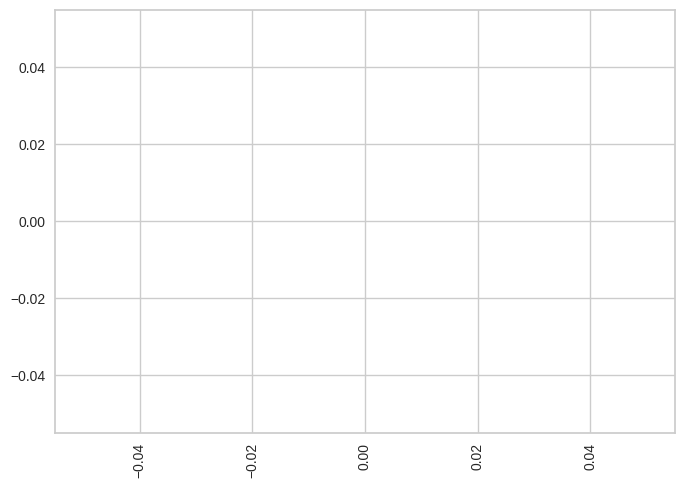

In [ ]:
pca = PCA(0)

X_pca = pca.fit_transform(scaled_x)

plt.bar(pca.get_feature_names_out(),
        pca.explained_variance_ratio_)

plt.xticks(rotation=90)

plt.show()

In [ ]:
linear_model_evaluation_test(lr.best_estimator_, X_pca, scaled_y, scaler_y)
linear_model_evaluation_test(lr_ridge.best_estimator_, X_pca, scaled_y, scaler_y)
linear_model_evaluation_test(lr_lasso.best_estimator_, X_pca, scaled_y, scaler_y)
linear_model_evaluation_test(svr.best_estimator_, X_pca, scaled_y, scaler_y)
linear_model_evaluation_test(knn.best_estimator_, X_pca, scaled_y, scaler_y)
linear_model_evaluation_test(tree.best_estimator_, X_pca, scaled_y, scaler_y)
linear_model_evaluation_test(rf.best_estimator_, X_pca, scaled_y, scaler_y)
linear_model_evaluation_test(rf_boosted.best_estimator_, X_pca, scaled_y, scaler_y)
linear_model_evaluation_test(mlp2.best_estimator_, scaled_x, scaled_y, scaler_y)

{'MAE (on test set)': 2110.709472012626, 'MAPE (on test set)': 0.4013083221873557}
{'MAE (on test set)': 2109.9774804125614, 'MAPE (on test set)': 0.40117871552113155}
{'MAE (on test set)': 2157.9005040926377, 'MAPE (on test set)': 0.41753914678782506}
{'MAE (on test set)': 2030.2711301517033, 'MAPE (on test set)': 0.37208506757710363}
{'MAE (on test set)': 2279.644186277972, 'MAPE (on test set)': 0.43813082379470536}
{'MAE (on test set)': 2611.7757596993815, 'MAPE (on test set)': 0.530698339334857}
{'MAE (on test set)': 2149.9719672578217, 'MAPE (on test set)': 0.42871513602188527}
{'MAE (on test set)': 2104.978943288795, 'MAPE (on test set)': 0.41550379623750894}


In [ ]:
linear_model_evaluation_test(mlp_best, scaled_x, scaled_y, scaler_y)

{'MAE (on test set)': 1502.6299977396347, 'MAPE (on test set)': 0.26243804174243485}


In [ ]:
# full_details_list = []
# with open('otodom_flats.csv', 'r') as handler:
#   reader = csv.reader(handler)
#   for it in reader:
#     res = eval(it[0].replace("'", '"'))
#     full_details_list.append(res)
# full_details_list